# Gedwongen oscilaties en resonantie

### Importeren packages

In [1]:
import numpy as np
import scipy.stats as nst
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
import pandas as pd
import fit_routine as ft
sp.init_printing()

In [2]:
plt.style.use("lab")

## Voorbereidende opgaves

**Vraag 1: herschrijven uitdrukkingen**

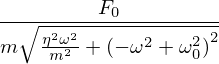

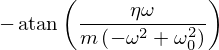

In [3]:
F0, m, omega0, omega, eta, k = sp.symbols("F0, m, omega0, omega, eta, k")
a_xw = F0/(m*sp.sqrt((omega0**2-omega**2)**2 + (omega*eta/m)**2))
var_a = [omega, omega0, m, eta, F0]
display(a_xw)
phi_w = -sp.atan((omega*eta/m)/(omega0**2-omega**2))
var_phi = [omega, omega0, m, eta]
display(phi_w)

In [4]:
phi, A, X, w, b = sp.symbols('phi, A, X, w, b')
eqA = sp.Eq(a_xw, A)
eqphi = sp.Eq(phi_w, phi)
eq1 = sp.Eq(X, F0/k)
eq2 = sp.Eq(w, omega/omega0)
eq3 = sp.Eq(b, eta/sp.sqrt(2*k*m))
eq4 = sp.Eq(omega0, sp.sqrt(k/m))

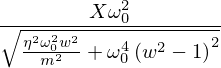

In [5]:
sols = sp.solve([eqA, eq1, eq2, eq3, eq4])
sols = sols[0]
sp.simplify(sols[A])

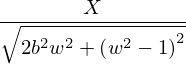

In [6]:
A_dim = X/sp.sqrt(2*w**2*b**2 + (w**2-1)**2)
display(A_dim)

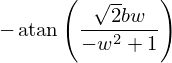

In [7]:
phi_dim = -sp.atan(sp.sqrt(2)*b*w/(1-w**2))
display(phi_dim)

Er treedt amplitude-resonantie op wanneer $w=1$, dus als $\omega = \omega_0$

### plots dimensieloze functies

In [9]:
# maak numerieke functies van de dimensiloze functies
A_dim_num = sp.lambdify([X, w, b], A_dim, "numpy")
phi_dim_num = sp.lambdify([X, w, b], phi_dim, "numpy")

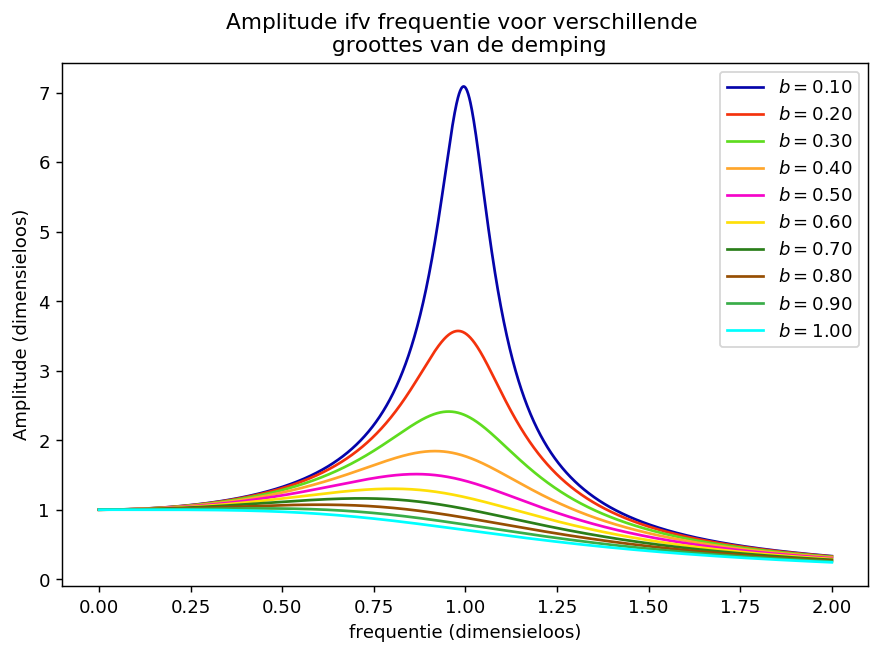

In [10]:
# definieer bereiken om te plotten
W = np.linspace(0, 2, 2000)
B = [(i+1)/10 for i in range(10)]
A_arr = [A_dim_num(1, W, demping) for demping in B]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(10):
    #ax = fig.add_subplot(5,2,i+1)
    ax.plot(W, A_arr[i], label="$b=%.2f$" %((i+1)/10))
    
ax.set_xlabel("frequentie (dimensieloos)")
ax.set_ylabel("Amplitude (dimensieloos)")
plt.title("Amplitude ifv frequentie voor verschillende \n groottes van de demping")
plt.legend()
    
plt.show()

In [11]:
# functie die atan2 gebruikt voor berekenen inverse tangens
def phi_atan2(X, w, b):
    return -np.arctan2(-np.sqrt(2)*b*w, -1+w**2)

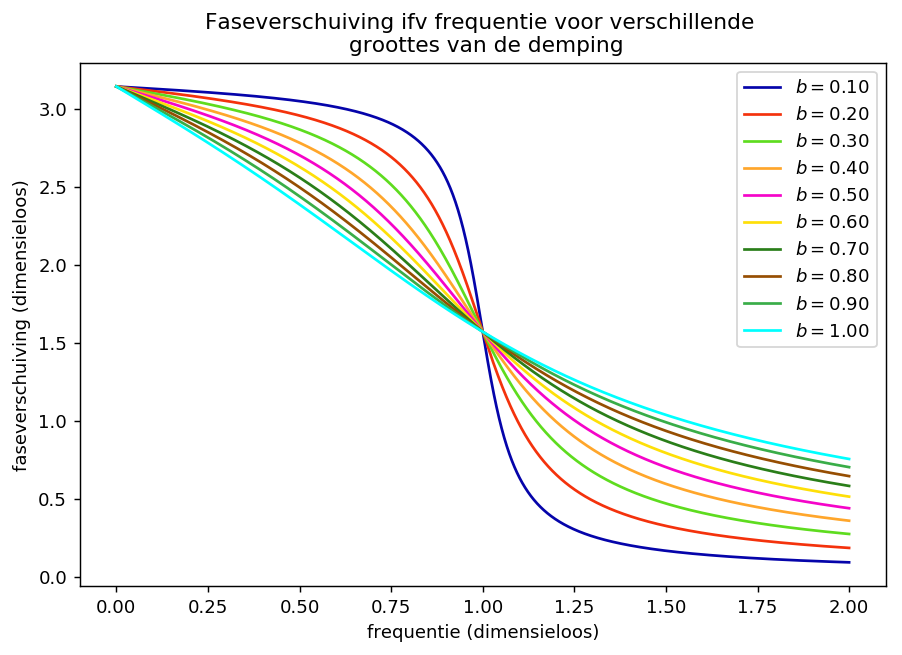

In [12]:
# definieer bereiken om te plotten
W = np.linspace(0, 2, 2000)
B = [(i+1)/10 for i in range(10)]
A_arr = [phi_atan2(1, W, demping) for demping in B]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(10):
    #ax = fig.add_subplot(5,2,i+1)
    ax.plot(W, A_arr[i], label="$b=%.2f$" %((i+1)/10))
    
ax.set_xlabel("frequentie (dimensieloos)")
ax.set_ylabel("faseverschuiving (dimensieloos)")
plt.title("Faseverschuiving ifv frequentie voor verschillende \n groottes van de demping")
plt.legend()
    
plt.show()

## Data practicum

In [33]:
df_small_res = pd.read_csv("Meting-resonantie-1.csv", header=None, names=["f", "df", "A", "dA", "phi", "dphi", "n"], sep=',')
#df_big_res = pd.read_excel("Meting-resonantie-2.csv", header=None, names=["f", "df", "A", "dA", "phi", "dphi", "n"], sep=',')
dsys_A = 0.002
dsys_fase = 1*np.pi/180

### De te fitten functies en methodes om te fitten

In [13]:
f_A = sp.lambdify(var_a, a_xw, "numpy")
def f_phi(omega, omega0, m, eta):
    return np.arctan2(eta*omega, -m*(omega**2-omega0**2))

In [14]:
# de volgorde van de parameters
display(var_a, var_phi)

### Fits kleine weerstand

transformeer de data naar numpy arrays

In [15]:
df_small_res.columns

Index(['f', 'df', 'A', 'dA', 'phi', 'dphi', 'n'], dtype='object')

In [34]:
df = df_small_res
sqrt_n = np.sqrt(df['n'])
f = df['f'].values
omega = 2*np.pi*f
domega = 2*np.pi*(df["df"]/sqrt_n)
domega = np.maximum(domega, 2*np.pi*0.01*np.ones_like(domega))
# Amplitude en fouten hierop, verander de eenheid naar meter
A = df['A'].values
# voeg ook de systematische fout toe aan de fout op de amplitude
dA = df['dA'].values/sqrt_n
dA = np.maximum(dA, dsys_A*np.ones_like(dA))
# de faseverschuiving en de fout hierop, verander naar radialen
fase = df['phi'] % 360
fase *= np.pi/180
dfase = df['dphi'] / sqrt_n
dfase *= np.pi/180
dfase = np.maximum(dfase, dsys_fase/np.sqrt(12)*np.ones_like(dfase))

In [44]:
fit = ft.fit(f_A, omega, A, dA, (10.5, 12, 8, 5), (0.01, 0.01, 0.01, 0.01))

/home/pieterluyten/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [20]:
for i in range(len(fit['param'])):
    display("%s: %f +- %f" %(str(var_a[i+1]), fit['param'][i], fit['stdv'][i][0][0]))

'omega0: 11.338502 +- -0.008253'

'm: 12.052264 +- -0.217224'

'eta: 8.307703 +- -0.088747'

'F0: 8.513498 +- -0.069264'

In [35]:
def dphi(x, a, b, c, d):
    return f_phi(x, a, b, c) - d
fit_fase = ft.fit(f_phi, omega, fase, dfase, (11, 8, 3.7), (0.01, 0.01, 0.01))
fit_fase2 = ft.fit(dphi, omega, fase, dfase, (11, 8, 3.7, -0.4), (0.01, 0.01, 0.01, 0.01))

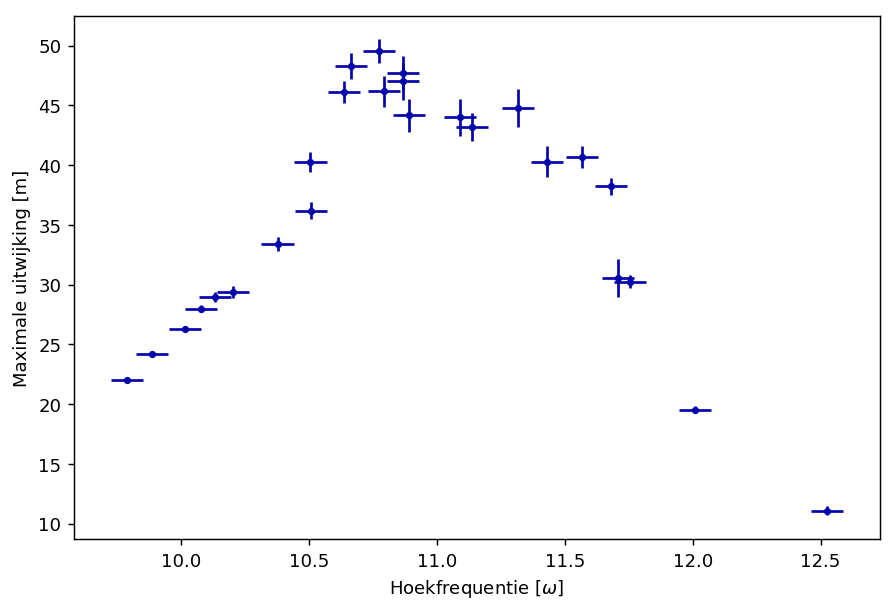

In [41]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.errorbar(omega, A, dA, domega, fmt='.')
#X = np.linspace(0.4, 15, 400)
#Y = [f_A(x, *fit['param']) for x in X]
#ax.plot(X, Y)
#X = np.linspace(0.4, 15, 400)
#Y = [f_A(x, *fit_fase['param'], fit['param'][-1]) for x in X]
#ax.plot(X, Y)
#X = np.linspace(0.4, 15, 400)
#Y = [f_A(x, *fit_fase2['param'][:-1], fit['param'][-1]) for x in X]
#ax.plot(X, Y)

ax.set_xlabel("Hoekfrequentie [$\omega$]")
ax.set_ylabel("Maximale uitwijking [m]")

plt.show()

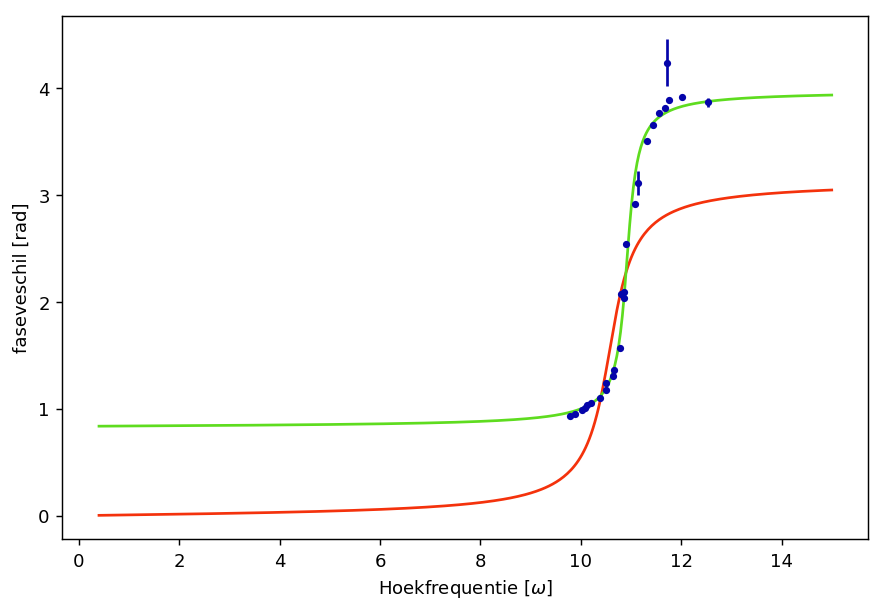

In [37]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.errorbar(omega, fase, dfase, fmt='.')
X = np.linspace(0.4, 15, 400)
Y = [f_phi(x, *fit_fase['param']) for x in X]
ax.plot(X, Y)
#X = np.linspace(0.4, 15, 400)
#Y = [f_phi(x, *fit['param'][:-1]) for x in X]
#ax.plot(X, Y)
X = np.linspace(0.4, 15, 400)
Y = [dphi(x, *fit_fase2['param']) for x in X]
ax.plot(X, Y)

ax.set_xlabel("Hoekfrequentie [$\omega$]")
ax.set_ylabel("faseveschil [rad]")

plt.show()

In [24]:
fit_fase

{'param': array([11.34514025,  6.49392627,  2.76762079]),
 'stdv': [(array([-0.00139156]), array([0.0013946])),
  (array([-0.05030217]), array([0.05073805])),
  (array([-0.02145621]), array([0.02160544]))],
 'p': 0.0}

In [25]:
fit

{'param': array([11.3385019 , 12.05226361,  8.3077027 ,  8.51349807]),
 'stdv': [(array([-0.00825258]), array([0.00820997])),
  (array([-0.21722424]), array([0.22204495])),
  (array([-0.08874717]), array([0.09032475])),
  (array([-0.06926395]), array([0.06926395]))],
 'p': 0.03663749418924045}

In [38]:
fit_fase2

{'param': array([10.92271792, 19.15927033,  6.09434153, -0.83512183]),
 'stdv': [(array([-0.00076092]), array([0.00076345])),
  (array([-0.08006269]), array([0.08054997])),
  (array([-0.02551474]), array([0.02557388])),
  (array([0.00124252]), array([-0.00124251]))],
 'p': 0.0}

### Fits grote weerstand

transformeer de data naar numpy arrays

In [27]:
df = df_big_res
f = df['Frequentie [Hz]'].values
omega = 2*np.pi*f
# Amplitude en fouten hierop, verander de eenheid naar meter
A = df['Amplitude [mm]'].values
A *= 0.001
# voeg ook de systematische fout toe aan de fout op de amplitude
dA = df['SD Amp [mm]'].values
dA *= 0.001
dA = np.maximum(dA, dsys_A*np.ones_like(dA))
# de faseverschuiving en de fout hierop, verander naar radialen
fase = df['Fase [°]']
fase *= np.pi/180
dfase = df['SD Fase [°]']
dfase *= np.pi/180
dfase = np.maximum(dfase, dsys_fase*np.ones_like(dfase))

In [39]:
fit = ft.fit(f_A, omega, A, dA, (10, 10, 10, 10), (0.01, 0.01, 0.01, 0.01))

/home/pieterluyten/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [29]:
for i in range(len(fit['param'])):
    display("%s: %f +- %f" %(str(var_a[i+1]), fit['param'][i], fit['stdv'][i][0][0]))

'omega0: 10.876109 +- -0.038287'

'm: 2.811483 +- -0.037499'

'eta: 15.735393 +- -0.129366'

'F0: 10.259011 +- -0.063170'

In [30]:
def dphi(x, a, b, c, d):
    return f_phi(x, a, b, c) - d
fit_fase = ft.fit(f_phi, omega, fase, dfase, (11, 8, 3.7), (0.01, 0.01, 0.01))
fit_fase2 = ft.fit(dphi, omega, fase, dfase, (11, 8, 3.7, -0.4), (0.01, 0.01, 0.01, 0.01))

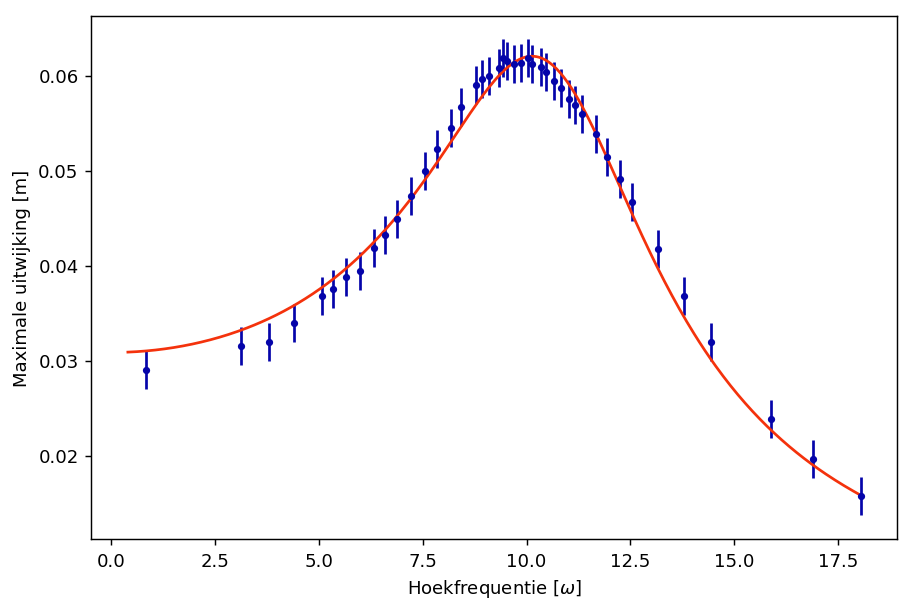

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.errorbar(omega, A, dA, fmt='.')
X = np.linspace(0.4, 18, 400)
Y = [f_A(x, *fit['param']) for x in X]
ax.plot(X, Y)
X = np.linspace(0.4, 18, 400)
Y = [f_A(x, *fit_fase['param'], fit['param'][-1]) for x in X]
#ax.plot(X, Y)
X = np.linspace(0.4, 18, 400)
Y = [f_A(x, *fit_fase2['param'][:-1], fit['param'][-1]) for x in X]
#ax.plot(X, Y)

ax.set_xlabel("Hoekfrequentie [$\omega$]")
ax.set_ylabel("Maximale uitwijking [m]")

plt.show()

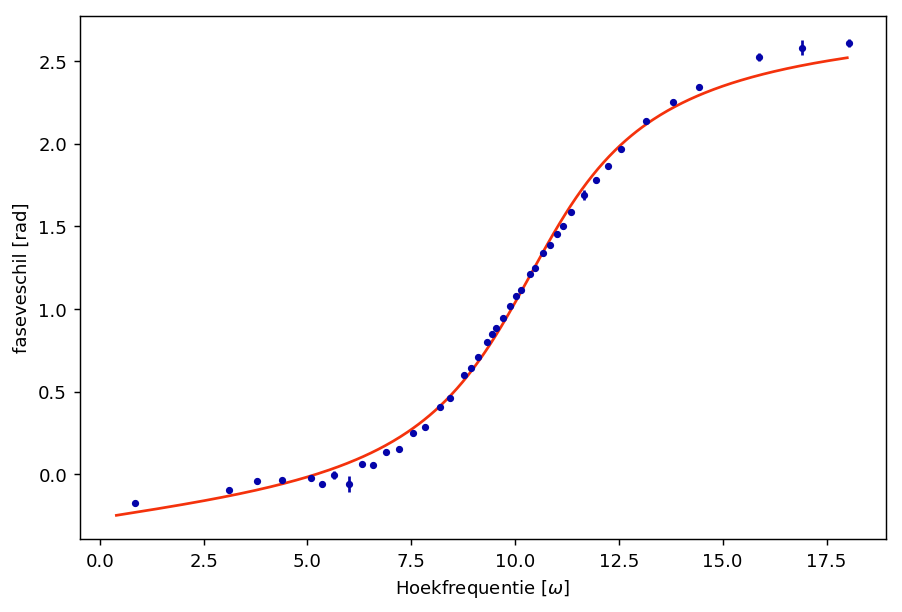

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.errorbar(omega, fase, dfase, fmt='.')
X = np.linspace(0.4, 18, 400)
Y = [f_phi(x, *fit_fase['param']) for x in X]
#ax.plot(X, Y)
X = np.linspace(0.4, 18, 400)
Y = [f_phi(x, *fit['param'][:-1]) for x in X]
#ax.plot(X, Y)
X = np.linspace(0.4, 18, 400)
Y = [dphi(x, *fit_fase2['param']) for x in X]
ax.plot(X, Y)

ax.set_xlabel("Hoekfrequentie [$\omega$]")
ax.set_ylabel("faseveschil [rad]")

plt.show()

In [33]:
fit_fase

{'param': array([11.35468876,  1.80895107,  7.62495894]),
 'stdv': [(array([-0.01014432]), array([0.01016])),
  (array([-0.01287325]), array([0.01297271])),
  (array([-0.05429228]), array([0.0546513]))],
 'p': 0.0}

In [34]:
fit

{'param': array([10.87610906,  2.81148279, 15.735393  , 10.25901061]),
 'stdv': [(array([-0.03828708]), array([0.03835242])),
  (array([-0.03749889]), array([0.03812804])),
  (array([-0.12936605]), array([0.13109707])),
  (array([-0.06317014]), array([0.06317013]))],
 'p': 0.998316484496763}

In [35]:
fit_fase2

{'param': array([10.59065006,  2.89790823, 12.79302288,  0.26408431]),
 'stdv': [(array([-0.00956927]), array([0.00957484])),
  (array([-0.02196926]), array([0.022137])),
  (array([-0.0969845]), array([0.09772572])),
  (array([-0.00280095]), array([0.00280097]))],
 'p': 0.0}